## Converting segmentation layout to the custom maps of heights

### Examples taken from the CityScapes fine-labelled dataset

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (24.0, 24.0)

In [3]:
default_example = 'vis1.jpg'
cityscapes_example = 'images/1.png'

In [4]:
im_path = cityscapes_example

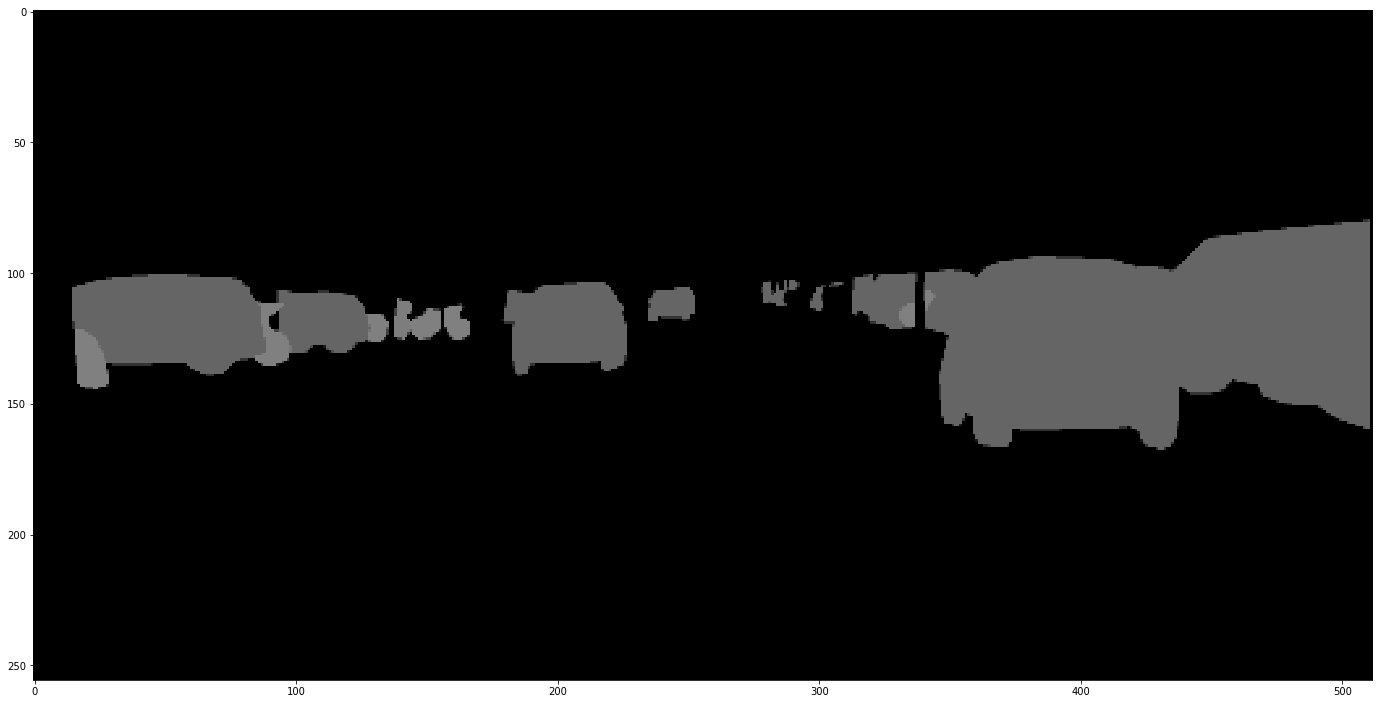

In [5]:
img = cv2.imread(im_path)
img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Set threshold for non-black part (segments). It corresponds to brightness threshold for grayscale (not standartized) and for L2-norm of RGB channels' values.

In [6]:
BACKGROUND_THRESHOLD = 1

In [7]:
def get_horizontal_map(img, mode='gray'):
    # return "map of the heights" for the input image (img)
    # mode switches between grayscale and multichannel mode
    new_img = np.zeros(img.shape[:2])
    for i, row in enumerate(img):
        new_img[i] = coded_row(get_interesting_points(row, mode), len(row))
    return new_img

In [8]:
def get_vertical_map(img, mode='gray'):
    # return "map of the heights" analogically to get_horizontal_map,
    # but vertical (twice uses transponation for it)
    if mode == 'rgb':
        return np.transpose(get_horizontal_map(np.transpose(img,axes=[1,0,2]), mode),axes=[1,0])
    else:
        return np.transpose(get_horizontal_map(np.transpose(img,axes=[1,0]), mode),axes=[1,0])        

In [9]:
def coded_row(interesting_points, length):
    # encodes the row of pixels correspondingly to the interesting points array
    # we don't need to calculate distance for each point, since we know all the
    # transitions (borders)
    background = interesting_points[0]
    interesting_points.append(length)
    interesting_points.pop(0)
    index = 0
    result = np.zeros((length))
    '''каждому пикселю поставить в соответствие число - 
    расстояние до границы (по вертикали и по горизонтали),
    отрицательные значения - мы на фоне и удаляемся от границы'''
    for i in interesting_points:
        if (i-index)%2 == 0:
            progression = list(range(0, (i-index)//2))
        else:
            progression = [0] + list(range(0, (i-index)//2))
        if background:
            
            result[index: i - (i-index)//2] = [-x for x in progression]    
            result[index + (i-index)//2: i] = [-x for x in reversed(progression)]
        else:   
            result[index: i - (i-index)//2] = progression
            result[index + (i-index)//2: i] = list(reversed(progression))
        
        background = not background
        index = i
    return result

In [10]:
def get_interesting_points(row, mode='rgb'):
    # encodes the row of raw pixels values into the list of border points
    # can be used in parallel to optimize the performance
    points = []
    if mode == 'rgb':
        nrow = np.apply_along_axis(lambda x: np.linalg.norm(x), 1, row)
    else:
        nrow = row
    
    if np.max(nrow) <= 1.:
        nrow = nrow * 255
    points.append(is_background(nrow[0]))
    for i in range(len(nrow) - 1):
        if is_background(nrow[i]) != is_background(nrow[i + 1]):
            points.append(i)
            
    return points

In [11]:
def is_background(pixel):
    return pixel <= BACKGROUND_THRESHOLD

In [12]:
def normalize(img):
    lower = np.min(img)
    upper = np.max(img)
    return (img - lower) / (abs(lower) + abs(upper))

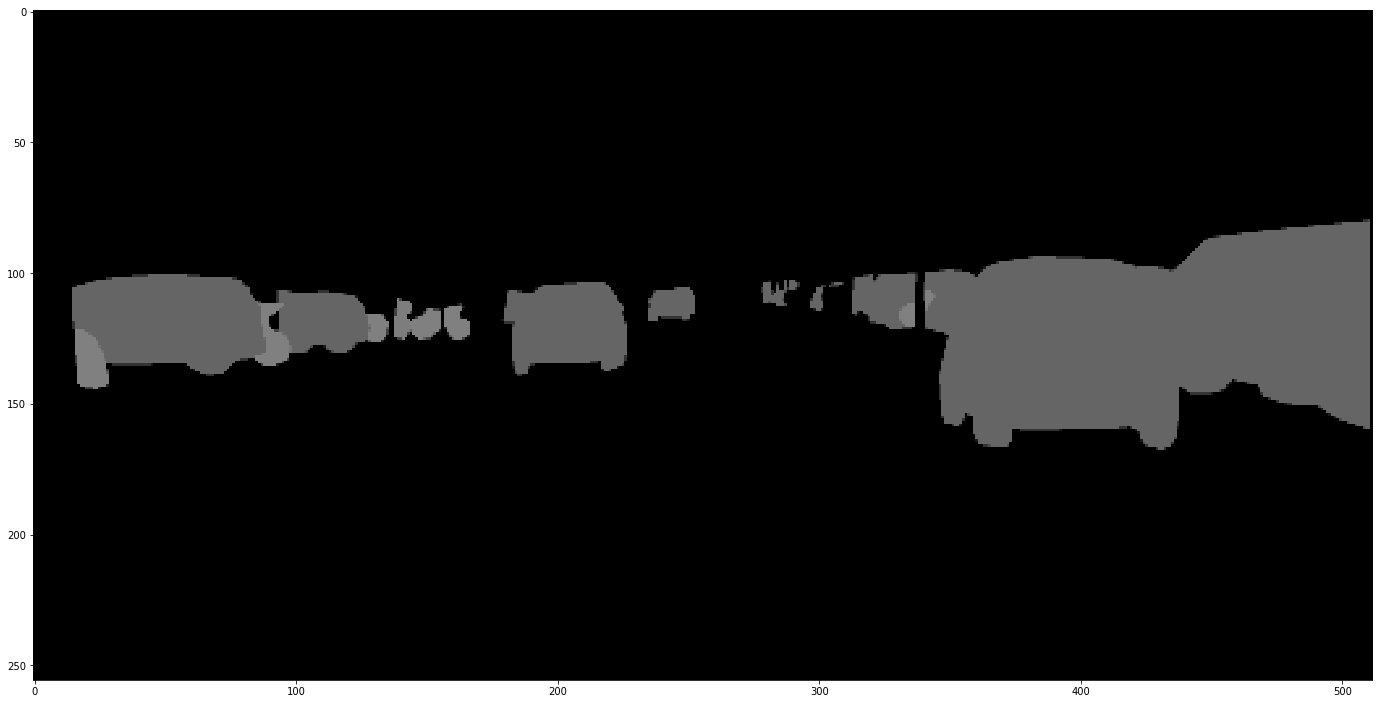

In [13]:
# Feel free to change the number of photo
im_path = 'images/1.png'
img = cv2.imread(im_path)
img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [14]:
hor_map = get_horizontal_map(img, mode = 'rgb')
ver_map = get_vertical_map(img, mode = 'rgb')

hor_map = normalize(hor_map)
ver_map = normalize(ver_map)

In [15]:
# in case you want to apply it to the colour photo and preserve "colour"

# BACKGROUND_THRESHOLD = 122
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# v_channel = hsv[:,:,2]
# hor_map = get_horizontal_map(v_channel)
# ver_map = get_vertical_map(v_channel)
# hsv[:,:,2] = hor_map
# hor_map = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# hsv[:,:,2] = ver_map
# ver_map = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

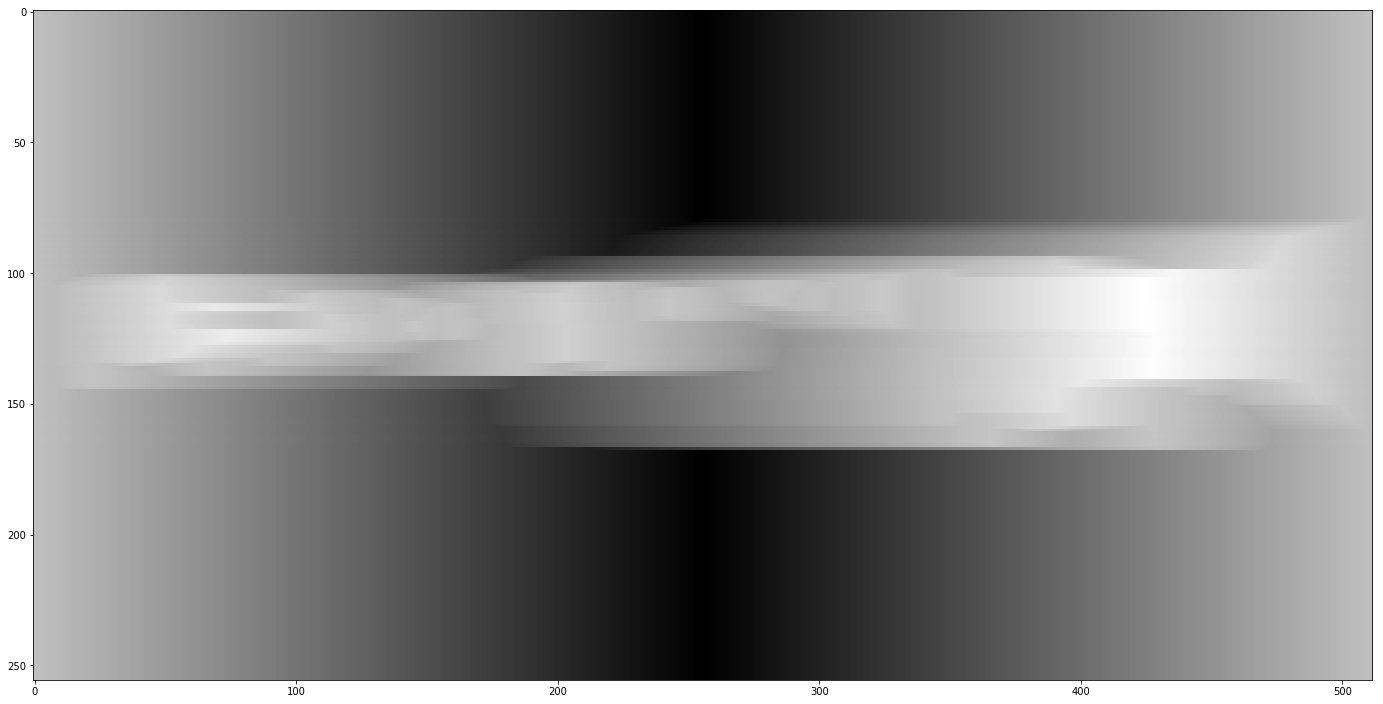

In [16]:
plt.imshow(hor_map, cmap='gray')

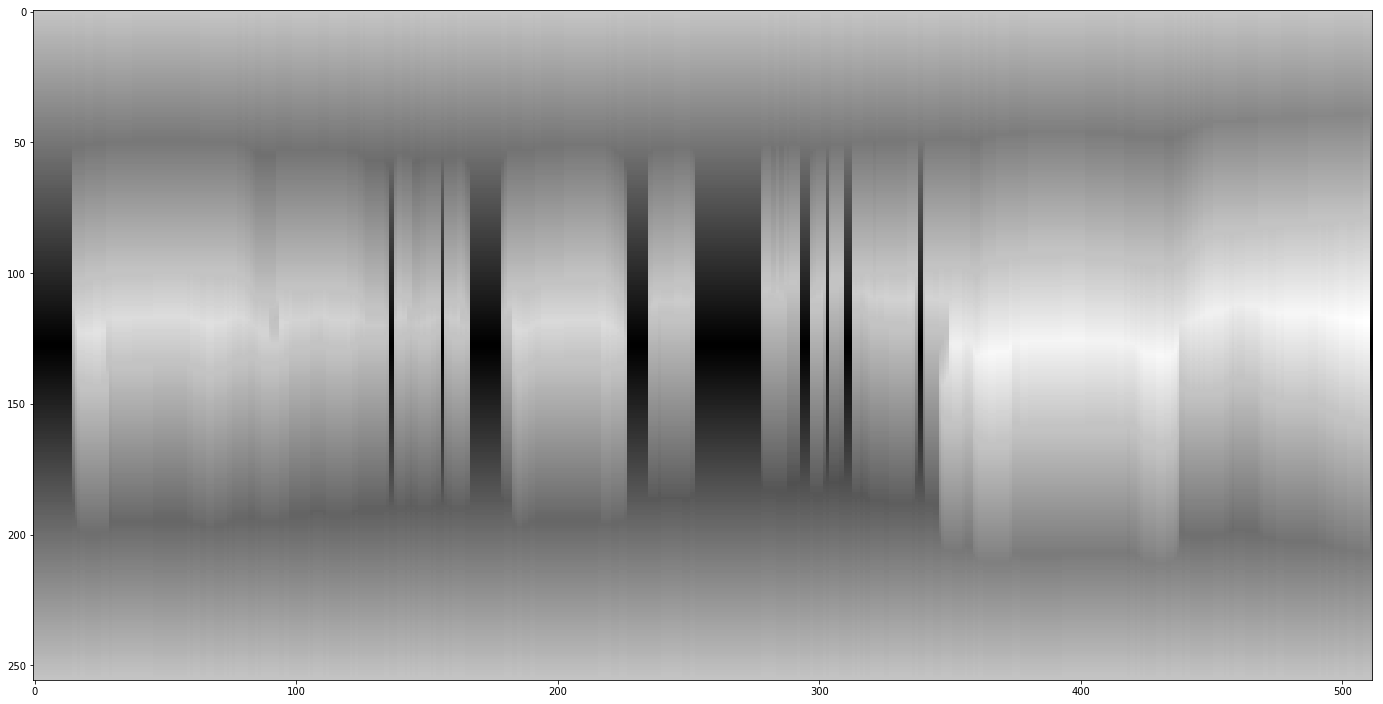

In [17]:
plt.imshow(ver_map, cmap='gray')